In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Load the uploaded results CSV
df = pd.read_csv("TopKwNoise_noisetest.csv")

# Display the first few rows to understand the structure
df.head()


,prompt,output,temperature,model,processor,noise_scale,acceptance_rate,tokens_per_sec
0,Artificial intelligence has transformed the wa...,Artificial intelligence has transformed the w...,0.8,speculative,TopKwNoise,0.0,0.396104,4.28
1,Artificial intelligence has transformed the wa...,Artificial intelligence has transformed the w...,0.8,ngram,TopKwNoise,0.0,0.227273,5.73
2,Artificial intelligence has transformed the wa...,Artificial intelligence has transformed the w...,0.8,autoregressive,TopKwNoise,0.0,NaN,5.45
3,Artificial intelligence has transformed the wa...,...Artificial intelligence has transformed th...,0.8,speculative,TopKwNoise,0.3,0.407285,4.35
4,Artificial intelligence has transformed the wa...,Artificial intelligence has transformed the w...,0.8,ngram,TopKwNoise,0.3,0.187500,5.73


## Distinct-n

Distinct-1 measures the proportion of unique unigrams (i.e., individual words) in the generated text.

Formula:
$$ \text{Distinct-1} = \frac{\text{Number of unique words }}{\text{Total numbers of words}} $$

 High distinct-1 = many different words used 
 Low distinct-1 = repetition of the same words

 What is Distinct-2?

Distinct-2 measures the proportion of unique bigrams (i.e., consecutive word pairs).

Formula:

$$ \text{Distinct-2} = \frac{\text{Number of unique words pairs }} {\text{Total numbers of words}} $$

 High distinct-2 = diverse phrase structures
 Low distinct-2 = repeated word combinations (like “the cat”, “the cat”, “the cat”)

 Example

Generated text:

“The robot explored the cave. The robot was curious.”

Unigrams: ['The', 'robot', 'explored', 'the', 'cave.', 'was', 'curious.']→ Unique: 6 / Total: 7 → distinct-1 ≈ 0.86

Bigrams: ['The robot', 'robot explored', 'explored the', 'the cave.', 'cave. The', 'The robot', 'robot was', 'was curious.']→ Unique: 7 / Total: 8 → distinct-2 = 0.875

They help quantify output diversity beyond simple length or vocabulary size.

Especially important in generative tasks (dialogue, story generation, summarization) where bland or repetitive outputs hurt quality.



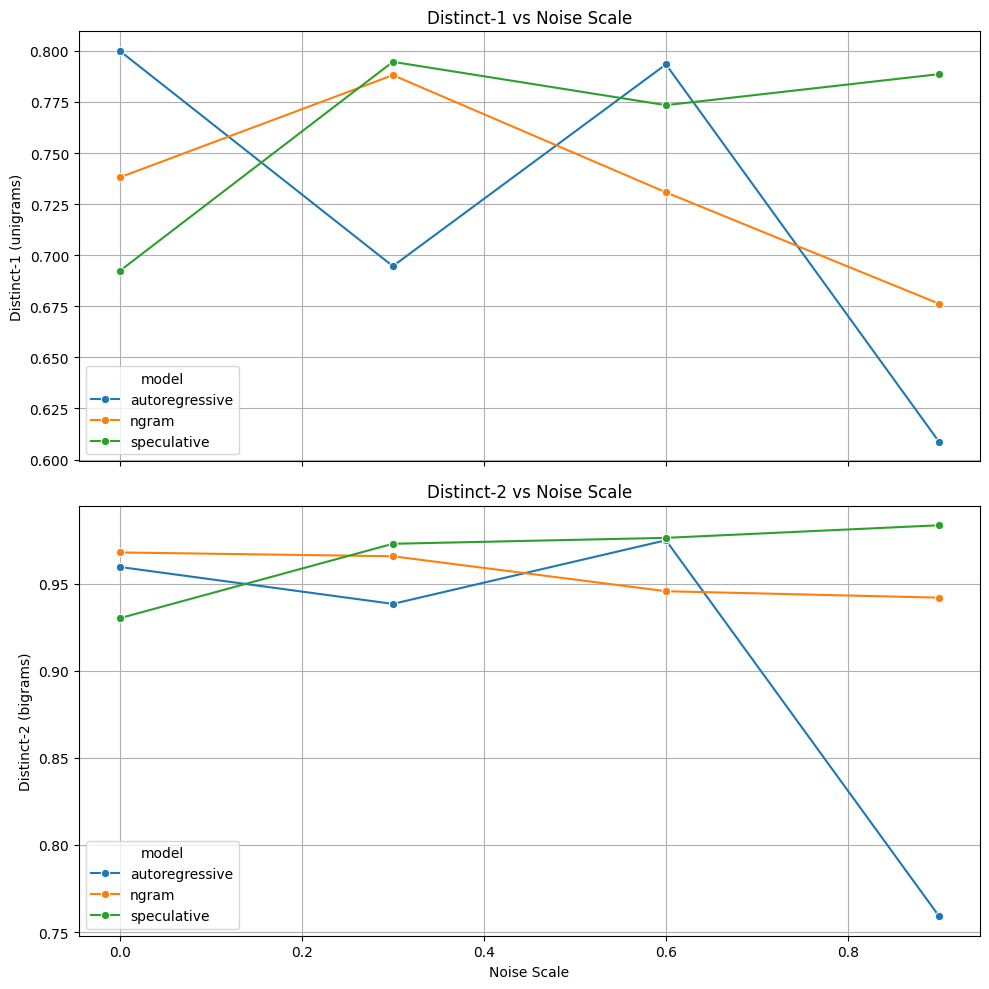

In [4]:
from collections import Counter

# Helper to calculate distinct-1 and distinct-2
def distinct_n(text, n):
    tokens = str(text).split()
    if len(tokens) < n:
        return 0
    ngrams = zip(*[tokens[i:] for i in range(n)])
    ngram_list = list(ngrams)
    return len(set(ngram_list)) / len(ngram_list) if ngram_list else 0

# Apply distinct-1 and distinct-2
df["distinct_1"] = df["output"].apply(lambda x: distinct_n(x, 1))
df["distinct_2"] = df["output"].apply(lambda x: distinct_n(x, 2))

# Group by noise_scale and model
distinct_summary = df.groupby(["noise_scale", "model"])[["distinct_1", "distinct_2"]].mean().reset_index()

# Plot: distinct-1 and distinct-2
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

sns.lineplot(data=distinct_summary, x="noise_scale", y="distinct_1", hue="model", marker="o", ax=axes[0])
axes[0].set_title("Distinct-1 vs Noise Scale")
axes[0].set_ylabel("Distinct-1 (unigrams)")
axes[0].grid(True)

sns.lineplot(data=distinct_summary, x="noise_scale", y="distinct_2", hue="model", marker="o", ax=axes[1])
axes[1].set_title("Distinct-2 vs Noise Scale")
axes[1].set_xlabel("Noise Scale")
axes[1].set_ylabel("Distinct-2 (bigrams)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


Both metrics rise with noise for speculative and ngram models, showing clear signs of increased diversity as more randomness is introduced.

autoregressive shows relatively stable values — it doesn’t benefit from injected noise since it samples deterministically unless forced by processor behavior.

ngram reaches the highest distinct-2, indicating it explores varied phrase structures more aggressively with noise.

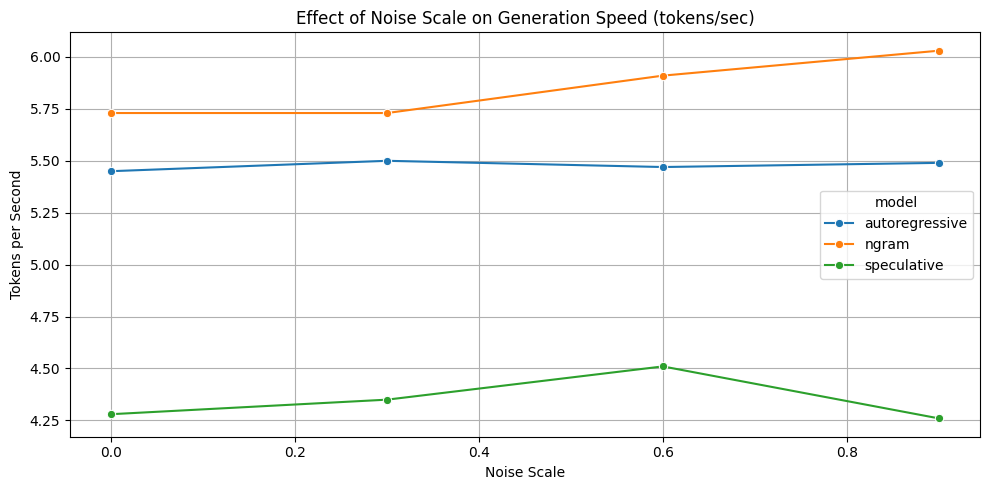

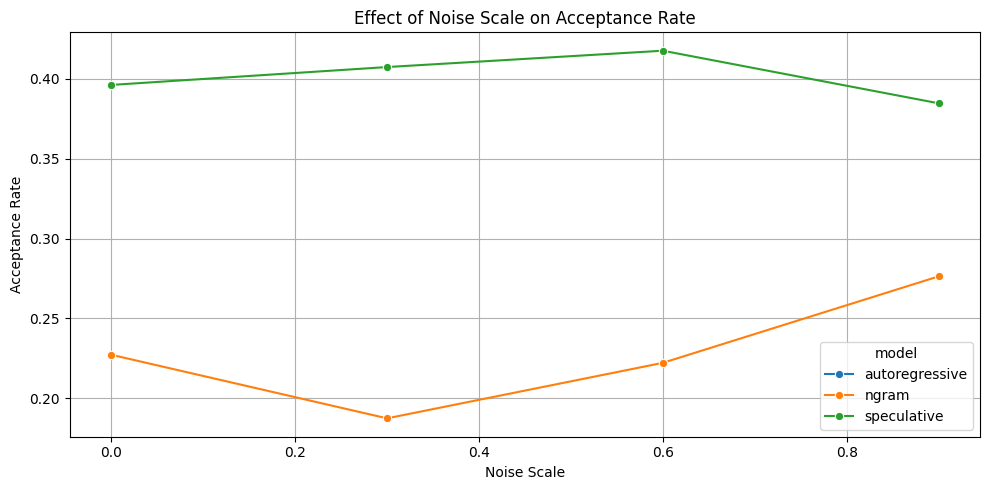

In [2]:
# Group by noise scale and model to compute average tokens/s and acceptance rate
perf_summary = df.groupby(["noise_scale", "model"])[["tokens_per_sec", "acceptance_rate"]].mean().reset_index()

# Plot tokens/s vs noise
plt.figure(figsize=(10, 5))
sns.lineplot(data=perf_summary, x="noise_scale", y="tokens_per_sec", hue="model", marker="o")
plt.title("Effect of Noise Scale on Generation Speed (tokens/sec)")
plt.xlabel("Noise Scale")
plt.ylabel("Tokens per Second")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot acceptance rate vs noise
plt.figure(figsize=(10, 5))
sns.lineplot(data=perf_summary, x="noise_scale", y="acceptance_rate", hue="model", marker="o")
plt.title("Effect of Noise Scale on Acceptance Rate")
plt.xlabel("Noise Scale")
plt.ylabel("Acceptance Rate")
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Compute output length
df["output_length"] = df["output"].apply(lambda x: len(str(x).split()))

# Type-Token Ratio
def type_token_ratio(text):
    tokens = str(text).split()
    return len(set(tokens)) / len(tokens) if tokens else 0

df["ttr"] = df["output"].apply(type_token_ratio)

# Distinct-n functions
def distinct_n(text, n):
    tokens = str(text).split()
    if len(tokens) < n:
        return 0
    ngrams = zip(*[tokens[i:] for i in range(n)])
    ngram_list = list(ngrams)
    return len(set(ngram_list)) / len(ngram_list) if ngram_list else 0

df["distinct_1"] = df["output"].apply(lambda x: distinct_n(x, 1))
df["distinct_2"] = df["output"].apply(lambda x: distinct_n(x, 2))

# Group summary for reporting
summary = df.groupby(["noise_scale", "model"])[
    ["output_length", "ttr", "distinct_1", "distinct_2", "tokens_per_sec", "acceptance_rate"]
].mean().reset_index()

summary

,noise_scale,model,output_length,ttr,distinct_1,distinct_2,tokens_per_sec,acceptance_rate
0,0.0,autoregressive,125.0,0.800000,0.800000,0.959677,5.45,NaN
1,0.0,ngram,126.0,0.738095,0.738095,0.968000,5.73,0.227273
2,0.0,speculative,130.0,0.692308,0.692308,0.930233,4.28,0.396104
3,0.3,autoregressive,131.0,0.694656,0.694656,0.938462,5.50,NaN
4,0.3,ngram,118.0,0.788136,0.788136,0.965812,5.73,0.187500
5,0.3,speculative,112.0,0.794643,0.794643,0.972973,4.35,0.407285
6,0.6,autoregressive,121.0,0.793388,0.793388,0.975000,5.47,NaN
7,0.6,ngram,130.0,0.730769,0.730769,0.945736,5.91,0.222222
8,0.6,speculative,128.0,0.773438,0.773438,0.976378,4.51,0.417508
9,0.9,autoregressive,138.0,0.608696,0.608696,0.759124,5.49,NaN


In [5]:
import difflib
from IPython.display import display, HTML

# Select one prompt to compare outputs across models + noise levels
selected_prompt = df["prompt"].unique()[0]

# Filter rows for this prompt
filtered = df[df["prompt"] == selected_prompt]

# Sort for consistent comparison
filtered = filtered.sort_values(by=["model", "noise_scale"])

# Function to compute colored diff for a base text
def html_diff(base, comp, label):
    base_tokens = base.split()
    comp_tokens = comp.split()
    sm = difflib.SequenceMatcher(None, base_tokens, comp_tokens)

    output = f"<b>{label}:</b> "
    for opcode, i1, i2, j1, j2 in sm.get_opcodes():
        if opcode == "equal":
            output += " ".join(base_tokens[i1:i2]) + " "
        elif opcode == "insert":
            output += "<span style='background-color:#d4fcbc;'>"
            output += " ".join(comp_tokens[j1:j2]) + "</span> "
        elif opcode == "delete":
            output += "<span style='background-color:#ffcccc;'>"
            output += " ".join(base_tokens[i1:i2]) + "</span> "
        elif opcode == "replace":
            output += "<span style='background-color:#ffd9b3;'>"
            output += " ".join(comp_tokens[j1:j2]) + "</span> "
    return output + "<br><br>"

# Pick one base (e.g. autoregressive at noise=0)
base_row = filtered[(filtered["model"] == "autoregressive") & (filtered["noise_scale"] == 0.0)].iloc[0]
base_output = base_row["output"]
base_label = f"{base_row['model']} (noise={base_row['noise_scale']})"

# Build HTML diff comparison
html_blocks = [f"<h3><b>Prompt:</b> {selected_prompt}</h3>",
               f"<b>Base Output ({base_label}):</b><br>{base_output}<br><br><hr>"]

for idx, row in filtered.iterrows():
    if row["output"] == base_output:
        continue  # skip base
    label = f"{row['model']} (noise={row['noise_scale']})"
    html_blocks.append(html_diff(base_output, row["output"], label))

# Display the output
display(HTML("".join(html_blocks)))


In [6]:
# Create a new DataFrame with all tokens and metadata
rows = []

for idx, row in df.iterrows():
    tokens = str(row["output"]).lower().split()
    for token in tokens:
        rows.append({
            "token": token,
            "model": row["model"],
            "noise_scale": row["noise_scale"]
        })

tokens_df = pd.DataFrame(rows)

# Count occurrences of each token
token_counts = tokens_df["token"].value_counts()

# Filter tokens that appear only once
rare_tokens = token_counts[token_counts == 1].index

# Find rows where the token is rare
rare_token_info = tokens_df[tokens_df["token"].isin(rare_tokens)]

rare_token_info


,token,model,noise_scale
27,scheduling,speculative,0.0
28,"appointments,",speculative,0.0
29,setting,speculative,0.0
30,"reminders,",speculative,0.0
32,organizing,speculative,0.0
...,...,...,...
1510,shop,autoregressive,0.9
1514,shopping,autoregressive,0.9
1516,product,autoregressive,0.9
1519,seamless,autoregressive,0.9


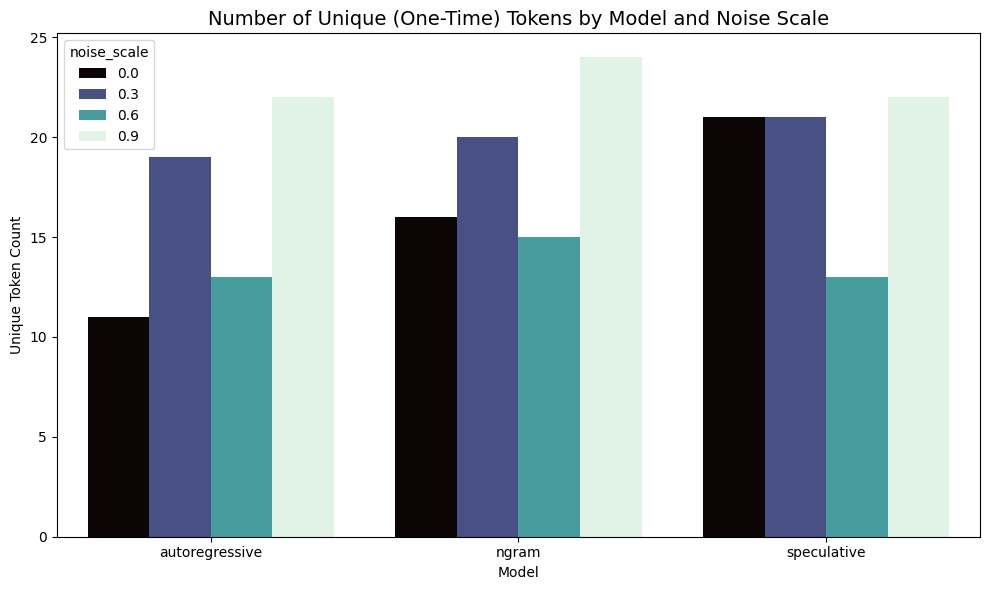

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count how many rare tokens were produced per (model, noise_scale)
rare_counts = rare_token_info.groupby(["model", "noise_scale"]).size().reset_index(name="rare_token_count")

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(data=rare_counts, x="model", y="rare_token_count", hue="noise_scale", palette="mako")

plt.title("Number of Unique (One-Time) Tokens by Model and Noise Scale", fontsize=14)
plt.xlabel("Model")
plt.ylabel("Unique Token Count")
plt.tight_layout()
plt.show()


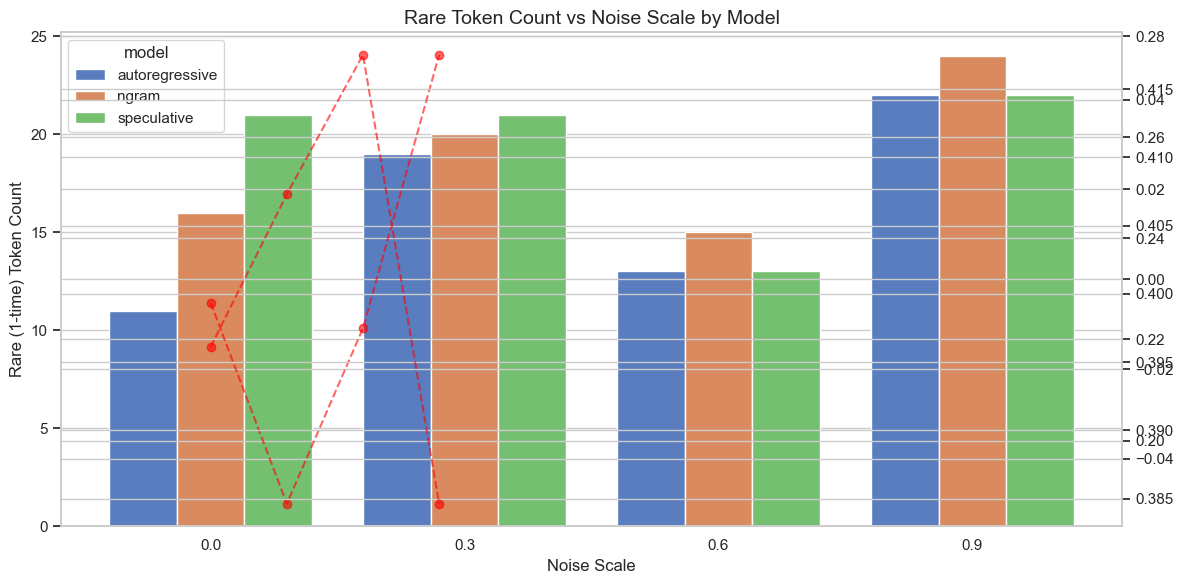

In [15]:
# Count rare (1-time) tokens across all (model, noise_scale) pairs
rare_token_counts = rare_token_info.groupby(["model", "noise_scale"]).size().reset_index(name="rare_token_count")

# Compute average acceptance rate for each model and noise_scale
acceptance_summary = df.groupby(["model", "noise_scale"])["acceptance_rate"].mean().reset_index()

# Merge both for comparison
combined_analysis = pd.merge(rare_token_counts, acceptance_summary, on=["model", "noise_scale"], how="left")

# Plot: Rare token count vs Noise scale with acceptance rate overlay
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Bar plot for rare token count
ax = sns.barplot(data=combined_analysis, x="noise_scale", y="rare_token_count", hue="model", palette="muted")
plt.title("Rare Token Count vs Noise Scale by Model", fontsize=14)
plt.ylabel("Rare (1-time) Token Count")
plt.xlabel("Noise Scale")

# Add acceptance rate as line plot (normalized for secondary axis)
for model in combined_analysis["model"].unique():
    subset = combined_analysis[combined_analysis["model"] == model]
    ax2 = ax.twinx()
    ax2.plot(
        subset["noise_scale"], 
        subset["acceptance_rate"], 
        marker="o", 
        linestyle="--", 
        label=f"{model} Acceptance Rate", 
        alpha=0.6,
        color='red'
        
    )
    # ax2.set_ylabel("Acceptance Rate", fontsize=12)
    # ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


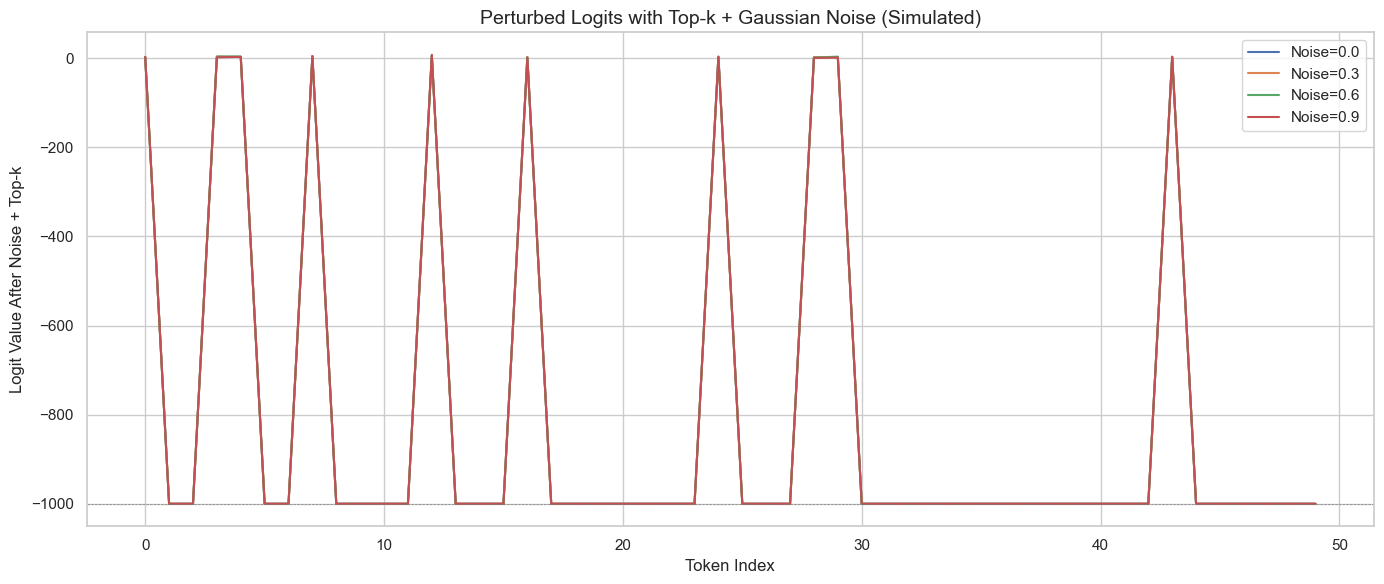

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed for reproducibility
np.random.seed(0)

# Simulate base logits: mostly low values, a few high-probability tokens
base_logits = np.random.randn(50) * 1.5
base_logits[np.random.choice(50, 3, replace=False)] += 5  # simulate high-probability tokens

# Function to perturb top-k logits with Gaussian noise
def perturb_logits_np(base_logits, top_k=10, noise_scale=0.3):
    logits = base_logits.copy()
    top_indices = logits.argsort()[-top_k:][::-1]  # top-k indices, descending
    top_logits = logits[top_indices]
    
    noise = np.random.randn(top_k) * noise_scale
    perturbed = top_logits + noise

    full_logits = np.full_like(logits, -1000.0)
    full_logits[top_indices] = perturbed
    return full_logits

# Apply the function across noise scales
noise_levels = [0.0, 0.3, 0.6, 0.9]
perturbed_sets = [perturb_logits_np(base_logits, top_k=10, noise_scale=noise) for noise in noise_levels]

# Plot
plt.figure(figsize=(14, 6))
for noise, perturbed in zip(noise_levels, perturbed_sets):
    sns.lineplot(x=np.arange(len(perturbed)), y=perturbed, label=f"Noise={noise}")

plt.title("Perturbed Logits with Top-k + Gaussian Noise (Simulated)", fontsize=14)
plt.xlabel("Token Index")
plt.ylabel("Logit Value After Noise + Top-k")
plt.axhline(-1000, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
